# Práctica 4: Modelos del Lenguaje Neuronales

**Fecha de entrega: 6 de abril de 2025 11:59pm**

A partir del modelo entrenado:

- Sacar los embeddings de las palabras del vocabulario

- Visualizar en 2D los embeddings de algunas palabras (quizá las más frecuentes, excluyendo stopwords)

- Seleccione algunas palabras y verifique sí realmente codifican nociones semánticas, e,g, similitud semántica con similitud coseno entre dos vectores, analogías por medios de operaciones de vectores

### Extra (0.5 pts):

- Correr el modelo de Bengio pero aplicando una técnica de subword tokenization al corpus y hacer generación del lenguaje

* La generación del lenguaje debe ser secuencias de palabras (no subwords)

## Referencias

- [Language models - Lena Voita](https://lena-voita.github.io/nlp_course/language_modeling.html#generation_strategies)
- [A Neural Probabilistic Model - Bengio](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)
- Parte del código de esta práctica fue retomado del trabajo de la Dr. Ximena Guitierrez Vasques

In [130]:
# Bibliotecas
import nltk

from nltk.corpus import reuters
from nltk.corpus import stopwords
from nltk.corpus import brown

import numpy as np
import re

from nltk import ngrams

# cargamos bibliotecas
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import time

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

nltk.download('brown')
nltk.download('reuters')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package brown to /home/aleksei935/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package reuters to
[nltk_data]     /home/aleksei935/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/aleksei935/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aleksei935/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Obtenemos funciones ya creadas del codigo

In [ ]:
UNK_LABEL = "<UNK>"
# Arquitectura de la red neuronal
class TrigramModel(nn.Module):
    """Clase padre: https://pytorch.org/docs/stable/generated/torch.nn.Module.html"""

    def __init__(self, vocab_size, embedding_dim, context_size, h):
        super(TrigramModel, self).__init__()
        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, h)
        self.linear2 = nn.Linear(h, vocab_size)

    def forward(self, inputs):
        # x': concatenation of x1 and x2 embeddings   -->
        # self.embeddings regresa un vector por cada uno de los índices que se les pase como entrada.
        # view() les cambia el tamaño para concatenarlos
        embeds = self.embeddings(inputs).view((-1,self.context_size * self.embedding_dim))
        # h: tanh(W_1.x' + b)  -->
        out = torch.tanh(self.linear1(embeds))
        # W_2.h                 -->
        out = self.linear2(out)
        # log_softmax(W_2.h)      -->
        # dim=1 para que opere sobre renglones, pues al usar batchs tenemos varios vectores de salida
        log_probs = F.log_softmax(out, dim=1)

        return log_probs
    
def get_word_id(words_indexes: dict, word: str) -> int:
    """Obtiene el id de una palabra dada

    Si no se encuentra la palabra se regresa el id
    del token UNK
    """
    unk_word_id = words_indexes[UNK_LABEL]
    return words_indexes.get(word, unk_word_id)


def get_train_test_data(corpus: list[list[str]], words_indexes: dict, n: int) -> tuple[list, list]:
    """Obtiene el conjunto de train y test

    Requerido en el step de entrenamiento del modelo neuronal
    """
    x_train = []
    y_train = []
    for sent in corpus:
        n_grams = ngrams(sent, n)
        for w1, w2, w3 in n_grams:
            x_train.append([get_word_id(words_indexes, w1), get_word_id(words_indexes, w2)])
            y_train.append([get_word_id(words_indexes, w3)])
    return x_train, y_train

Hay que sacar los word indexes

Para sacar los embbeddings necesitamos:

1. Preprocesamos corpus
2. Tokenizamos (creamos vocabulario)
3. Obtenemos frequencia de tokens(vocab)
4. Obtenemos diccionario word_to_index y index_to_word
5. Creamos el modelo de trigramas con el corpus preprocesado y el diccionario word_to_index




In [83]:
def preprocess_brown_corpus(remove_stopwords=True) -> tuple[list[list[str]], dict, dict, dict]:
    """
    Preprocesa el corpus Brown para modelos neuronales de lenguaje:
    1. Convierte a minúsculas, agrega <BOS> y <EOS> (Funcion preprocess_corpus)
    2. Elimina stopwords ( agregamos para remover stopwords)
    3. Calcula frecuencias de palabras (Funcion get_words_freqs)
    4. Genera diccionarios word_to_index y index_to_word (Funcion get_words_indexes)

    Returns:
        preprocessed_corpus: Corpus listo para entrenamiento
        words_freqs: Frecuencias de palabras
        words_indexes: Diccionario palabra->índice
        index_to_word: Diccionario índice->palabra
    """

    stop_words = set(stopwords.words('english')) if remove_stopwords else set()
    # Brown ya está tokenizado por oraciones
    raw_corpus = brown.sents()
    preprocessed_corpus = []
    for sent in raw_corpus:
        # Lowercase y filtrado de stopwords
        filtered = [w.lower() for w in sent if not (remove_stopwords and w.lower() in stop_words)]
        filtered = [re.sub(r"[^a-zA-ZáéíóúñÁÉÍÓÚÑ]", '', w) for w in filtered]

        if not filtered:
            continue
        filtered.append("<EOS>")
        filtered.insert(0, "<BOS>")

        preprocessed_corpus.append(filtered)

    # Calcular frecuencias
    words_freqs = {}
    for sentence in preprocessed_corpus:
        for word in sentence:
            words_freqs[word] = words_freqs.get(word, 0) + 1

    # Diccionarios de índices
    result = {}
    for idx, word in enumerate(words_freqs.keys()):
        if words_freqs[word] == 1:
            result[UNK_LABEL] = len(words_freqs)
        else:
            result[word] = idx
    words_indexes = {word: idx for idx, word in enumerate(result.keys())}
    index_to_word = {idx: word for idx, word in enumerate(result.keys())}

    return preprocessed_corpus, words_freqs, words_indexes, index_to_word


In [84]:
brown_corpus, brown_words_freqs, brown_words_indexes, brown_index_to_word = preprocess_brown_corpus()

In [85]:
# Setup de parametros
EMBEDDING_DIM = 200
CONTEXT_SIZE = 2
BATCH_SIZE = 256
H = 100
torch.manual_seed(42)
# Tamaño del Vocabulario
V = len(brown_words_indexes)

In [86]:
x_train, y_train = get_train_test_data(brown_corpus, words_indexes, n=3)

train_set = np.concatenate((x_train, y_train), axis=1)
# partimos los datos de entrada en batches
train_loader = DataLoader(train_set, batch_size = BATCH_SIZE)

In [87]:
# Seleccionar la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [88]:
#torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device {device}")

# 1. Pérdida. Negative log-likelihood loss
loss_function = nn.NLLLoss()

# 2. Instanciar el modelo y enviarlo a device
model = TrigramModel(V, EMBEDDING_DIM, CONTEXT_SIZE, H).to(device)

# 3. Optimización. ADAM optimizer
optimizer = optim.Adam(model.parameters(), lr = 2e-3)

# ------------------------- TRAIN & SAVE MODEL ------------------------
EPOCHS = 3
for epoch in range(EPOCHS):
    st = time.time()
    print("\n--- Training model Epoch: {} ---".format(epoch))
    for it, data_tensor in enumerate(train_loader):
        # Mover los datos a la GPU
        context_tensor = data_tensor[:,0:2].to(device)
        target_tensor = data_tensor[:,2].to(device)

        model.zero_grad()

        # FORWARD:
        log_probs = model(context_tensor)

        # compute loss function
        loss = loss_function(log_probs, target_tensor)

        # BACKWARD:
        loss.backward()
        optimizer.step()

        if it % 500 == 0:
            print("Training Iteration {} of epoch {} complete. Loss: {}; Time taken (s): {}".format(it, epoch, loss.item(), (time.time()-st)))
            st = time.time()

    # saving model
    model_path = f'./model_{device}_context_{CONTEXT_SIZE}_epoch_{epoch}.dat'
    torch.save(model.state_dict(), model_path)
    print(f"Model saved for epoch={epoch} at {model_path}")


Training on device cuda

--- Training model Epoch: 0 ---
Training Iteration 0 of epoch 0 complete. Loss: 10.25779914855957; Time taken (s): 0.09166789054870605
Training Iteration 500 of epoch 0 complete. Loss: 4.739955902099609; Time taken (s): 1.2875478267669678
Training Iteration 1000 of epoch 0 complete. Loss: 5.8794846534729; Time taken (s): 1.0670349597930908
Training Iteration 1500 of epoch 0 complete. Loss: 5.927773952484131; Time taken (s): 1.0580964088439941
Training Iteration 2000 of epoch 0 complete. Loss: 5.327678203582764; Time taken (s): 1.0602531433105469
Training Iteration 2500 of epoch 0 complete. Loss: 4.493918418884277; Time taken (s): 1.061180830001831
Model saved for epoch=0 at ./model_cuda_context_2_epoch_0.dat

--- Training model Epoch: 1 ---
Training Iteration 0 of epoch 1 complete. Loss: 6.474738597869873; Time taken (s): 0.0035533905029296875
Training Iteration 500 of epoch 1 complete. Loss: 4.626623630523682; Time taken (s): 1.0681161880493164
Training Iterat

In [94]:
model

TrigramModel(
  (embeddings): Embedding(26605, 200)
  (linear1): Linear(in_features=400, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=26605, bias=True)
)

In [95]:
def get_model(path: str) -> TrigramModel:
    """Obtiene modelo de pytorch desde disco"""
    model_loaded = TrigramModel(V, EMBEDDING_DIM, CONTEXT_SIZE, H)
    model_loaded.load_state_dict(torch.load(path))
    model_loaded.eval()
    return model_loaded

In [96]:
PATH = "./model_cuda_context_2_epoch_2.dat"
model = get_model(PATH)

Obtenemos los embeddings de las palabras

In [97]:
embeddings = model.embeddings.weight.data.cpu().numpy()
embeddings.shape

# Embeddings de palabras
print("Embeddings de palabras", len(embeddings))
print("Número de palabras:", len(brown_words_indexes))

Embeddings de palabras 26605
Número de palabras: 26605


Visualizamos los embeddings de las siguientes palabras:
`
    (3297, 'one'),
    (2714, 'would'),
    (1961, 'said'),
    (1635, 'new'),
    (1601, 'could'),
    (1598, 'time'),
    (1412, 'two')
`

In [100]:
# Ordenar por frecuencia
brown_words_freqs_sorted = sorted(((freq, word) for word, freq in brown_words_freqs.items()), reverse=True)
words_to_visualize = brown_words_freqs_sorted[3:10]

id_for_words_to_visualize = [ get_word_id(brown_words_indexes, word) for _, word in words_to_visualize]

In [110]:
# Obtener los embeddings de las palabras
embeddings_for_words_to_visualize =  np.array([embeddings[idx] for idx in id_for_words_to_visualize])
embeddings_for_words_to_visualize.shape


(7, 200)

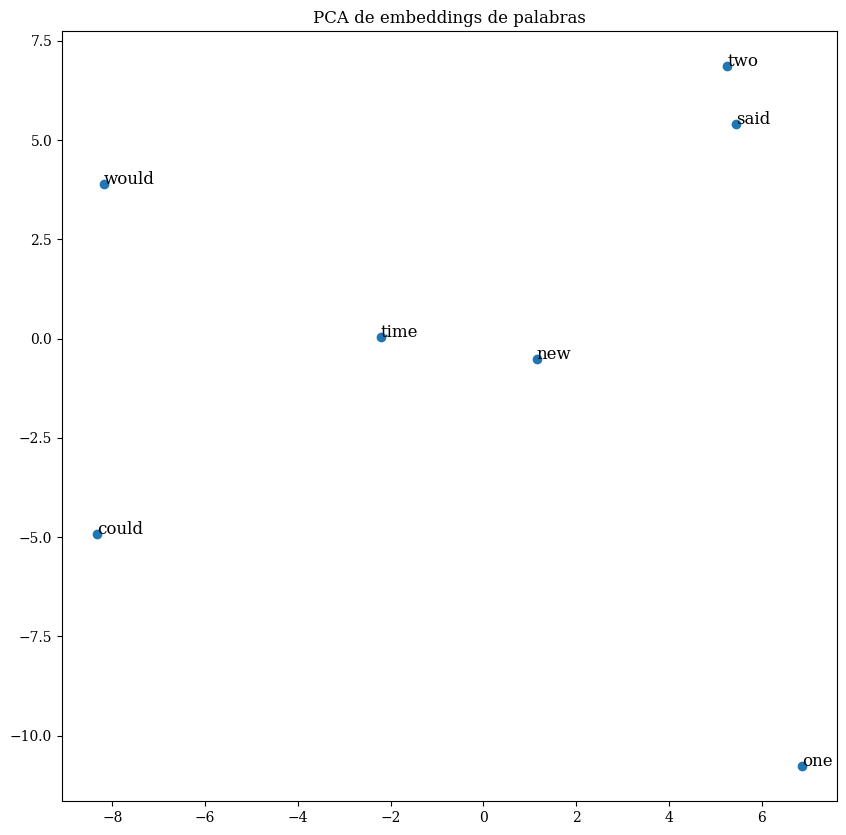

In [112]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib as mpl

# Desactivar LaTeX en matplotlib
mpl.rcParams['text.usetex'] = False

# Visualización
plt.figure(figsize=(10, 10))
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings_for_words_to_visualize)

plt.scatter(pca_result[:, 0], pca_result[:, 1])
for i, word in enumerate(words_to_visualize):
    plt.annotate(word[1], xy=(pca_result[i, 0], pca_result[i, 1]), fontsize=12)

plt.title("PCA de embeddings de palabras")
plt.show()


In [ ]:
words_to_visualize = brown_words_freqs_sorted[30:40]

# Palabras a analizar
selected_words = [w for _, w in words_to_visualize]
selected_ids = [get_word_id(brown_words_indexes, w) for w in selected_words]
selected_embeddings = np.array([embeddings[idx] for idx in selected_ids])

# Matriz de similitud coseno
similarity_matrix = cosine_similarity(selected_embeddings)

print("Matriz de similitud coseno entre palabras seleccionadas:")
print(f"{'':>10}", end="")
for w in selected_words:
    print(f"{w:>10}", end="")
print()
for i, w1 in enumerate(selected_words):
    print(f"{w1:>10}", end="")
    for j, w2 in enumerate(selected_words):
        print(f"{similarity_matrix[i, j]:10.2f}", end="")
    print()



Matriz de similitud coseno entre palabras seleccionadas:
                good      make     world     still       see       men      work      long       get      life
      good      1.00      0.07      0.19      0.05      0.00      0.06     -0.01      0.16      0.02      0.06
      make      0.07      1.00     -0.04     -0.07      0.02      0.10      0.06     -0.06     -0.07      0.03
     world      0.19     -0.04      1.00      0.03     -0.05     -0.04      0.06      0.11     -0.17     -0.02
     still      0.05     -0.07      0.03      1.00     -0.09      0.00     -0.11     -0.09     -0.08     -0.02
       see      0.00      0.02     -0.05     -0.09      1.00     -0.10     -0.03     -0.10     -0.14     -0.08
       men      0.06      0.10     -0.04      0.00     -0.10      1.00     -0.01      0.03     -0.01      0.01
      work     -0.01      0.06      0.06     -0.11     -0.03     -0.01      1.00     -0.03      0.09     -0.01
      long      0.16     -0.06      0.11     -0.09     

In [137]:
vec = embeddings[get_word_id(brown_words_indexes, "one")] \
    - embeddings[get_word_id(brown_words_indexes, "man")] \
    + embeddings[get_word_id(brown_words_indexes, "life")]

# Buscar la palabra más cercana excluyendo las originales
def most_similar(vec, embeddings, index_to_word, exclude_ids, topn=5):
    sims = cosine_similarity([vec], embeddings)[0]
    best = np.argsort(-sims)
    result = []
    for idx in best:
        if idx not in exclude_ids:
            result.append((index_to_word[idx], sims[idx]))
        if len(result) == topn:
            break
    return result

analogy_result = most_similar(vec, embeddings, brown_index_to_word, exclude_ids=selected_ids)
print("\nResultado de la analogía 'one' - 'man' + 'life':")
for word, score in analogy_result:
    print(f"{word}: {score:.2f}")


Resultado de la analogía 'one' - 'man' + 'life':
one: 0.60
soak: 0.31
ith: 0.28
department: 0.27
insubordination: 0.24
